<img align="left" src="imgs/logo.jpg" width="50px" style="margin-right:10px">

# Snorkel Workshop: Extracting Spouse Relations <br> from the News
## Part 3: Training the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [52]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# I. Loading Data

First we'll load our label matrices from notebook 2

In [60]:
dev_data = pd.read_pickle("dev_data.pkl")
dev_labels = np.load("dev_labels.npy")
dev_L = np.load('dev_L.npy').item()

In [61]:
dev_L

<2811x7 sparse matrix of type '<class 'numpy.int64'>'
	with 1054 stored elements in Compressed Sparse Row format>

# II: Unifying supervision

## Generative Model
In data programming, we use a more sophisitcated model to unify our labeling functions. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a generative model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which we will then use to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

**NOTE: Make sure you've written some of your own LFs in the previous notebook to get a decent score!!!**

### 1. Training the Model
When training the generative model, we'll tune our hyperparamters using a simple grid search. 

**Parameter Definitions**
    
    epochs     A single pass through all the data in your training set
    step_size  The factor by which we update model weights after computing the gradient
    decay      The rate our update factor dimishes (decay) over time.
    

In [68]:
import sys
sys.path.append('../..')

from snorkel.labeling.model.baselines import MajorityLabelVoter
from snorkel.labeling.model.label_model import LabelModel
from snorkel.model.utils import plusminus_to_categorical

dev_L_converted = plusminus_to_categorical(dev_L.toarray())

label_model = LabelModel(k=2, verbose=True)
label_model.train_model(
            dev_L_converted,
            class_balance=[0.2,0.8],
            n_epochs=5000,
            log_train_every=500,
        )

Computing O...
Estimating \mu...
[500 epo]: TRAIN:[loss=0.006]
[1000 epo]: TRAIN:[loss=0.004]
[1500 epo]: TRAIN:[loss=0.004]
[2000 epo]: TRAIN:[loss=0.004]
[2500 epo]: TRAIN:[loss=0.004]
[3000 epo]: TRAIN:[loss=0.004]
[3500 epo]: TRAIN:[loss=0.004]
[4000 epo]: TRAIN:[loss=0.004]
[4500 epo]: TRAIN:[loss=0.004]
[5000 epo]: TRAIN:[loss=0.004]
Finished Training


### 2. Model Accuracies
These are the weights learned for each LF

In [72]:
score = label_model.score((dev_L_converted, plusminus_to_categorical(dev_labels)), metric=['accuracy','f1', 'precision', 'recall'])

Accuracy: 0.891
F1: 0.414
Precision: 0.332
Recall: 0.547
        y=1    y=2   
 l=1    104    209   
 l=2    86    2304   


In [70]:
train_marginals = label_model.predict_proba(dev_L_converted)

### 3. Plotting Marginal Probabilities
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training marginals. Ideally, there should get a bimodal distribution with large seperation between each peaks, as shown below by the far right image. The corresponds to good signal for true and positive class labels. For your first Snorkel application, you'll probably see marginals closer to the far left or middle images. With all mass centered around p=0.5, you probably need to write more LFs got get more overall _coverage_. In the middle image, you have good negative coverage, but not enough positive LFs

<img align="left" src="imgs/marginals-common.jpg" width="265px" style="margin-right:0px">

<img align="left" src="imgs/marginals-real.jpg" width="265px" style="margin-right:0px">

<img align="left" src="imgs/marginals-ideal.jpg" width="265px" style="margin-right:0px">


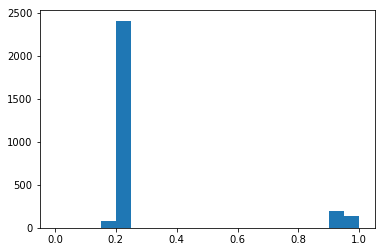

In [71]:
import matplotlib.pyplot as plt
plt.hist(train_marginals[:,0], bins=20, range=(0.0, 1.0))
plt.show()

### 4. Generative Model Metrics

In [59]:
dev_marginals = label_model.marginals(L_dev)
_, _, _, _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

NameError: name 'gen_model' is not defined

### 5. Saving our training labels

Finally, we'll save the `training_marginals`, which are our **"noise-aware training labels"**, so that we can use them in the next tutorial to train our end extraction model:

In [8]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 22254 marginals
CPU times: user 9.5 s, sys: 18.3 ms, total: 9.51 s
Wall time: 9.52 s
